# SimPy

In [1]:
!pip3 install simpy

In [0]:
import pandas as pd

import simpy

## Conceitos básicos

_______________

O comportamento de **componentes ativos** (veículos, clientes, passageiros, peças em uma linha de produção, etc.) é modelado com **processos (processes)**.

Todos os **processos** vivem em um **ambiente (environment)**

Os processos interagem entre si e com o ambiente por meio de **eventos** (por isso o nome simulação de *eventos* discretos)

__________

Os processos são descritos por ```generators``` de Python.

Durante sua vida, eles criam eventos e os entregam (```yield```) e espera até que sejam acionados.

Quando um processo gera um evento, o processo é suspenso. O SimPy retoma o processo, quando o evento ocorre (dizemos que o evento é acionado).

Um tipo de evento importante é o ```timeout```.

Eventos desse tipo são acionados após uma certa quantidade de tempo (simulado) ter passado. Eles permitem que um processo durma (ou mantenha seu estado) pelo tempo determinado.

Um ```timeout``` e todos os outros eventos podem ser criados chamando o método apropriado do ```Environment``` no qual o processo reside (```Environment.timeout()```, por exemplo).

### 1 - Um gerador de clientes

In [0]:
def client_generator(env):
    client_number = 0
    while True:
        client_number += 1
        print(f'Cliente {client_number} chegou!')
        yield env.timeout(30)

In [4]:
env = simpy.Environment()
env.process(client_generator(env))
env.run(until=100)

Cliente 1 chegou!
Cliente 2 chegou!
Cliente 3 chegou!
Cliente 4 chegou!


### 2 - Um caixa de banco (```Resource```)

```Resource.request()``` pede acesso ao recurso (ex: entra na fila se houver, ou ocupa o caixa se não houver ninguém lá)

```Resource.release()``` solta o acesso ao recurso (ex: sai do caixa e deixa o próximo da fila ir)



### 3 - Um cliente no caixa

In [0]:
def client(env, caixa, client_number):
    req = caixa.request()
    yield req
    print(f'{env.now} Cliente {client_number} foi atendido!')
    yield env.timeout(25)  ## Tempo que dura o atendimento
    caixa.release(req)
    print(f'{env.now} Cliente {client_number} foi embora!')

def client_generator(env, caixa):
    client_number = 0
    while True:
        client_number += 1
        print(f'{env.now} Cliente {client_number} chegou!')
        env.process(client(env, caixa, client_number))
        yield env.timeout(5)  ## De quanto em quanto tempo chega um novo cliente

In [7]:
env = simpy.Environment()
caixa = simpy.Resource(env, capacity=5)
env.process(client_generator(env, caixa))
env.run(until=100)

0 Cliente 1 chegou!
0 Cliente 1 foi atendido!
5 Cliente 2 chegou!
5 Cliente 2 foi atendido!
10 Cliente 3 chegou!
10 Cliente 3 foi atendido!
15 Cliente 4 chegou!
15 Cliente 4 foi atendido!
20 Cliente 5 chegou!
20 Cliente 5 foi atendido!
25 Cliente 1 foi embora!
25 Cliente 6 chegou!
25 Cliente 6 foi atendido!
30 Cliente 2 foi embora!
30 Cliente 7 chegou!
30 Cliente 7 foi atendido!
35 Cliente 3 foi embora!
35 Cliente 8 chegou!
35 Cliente 8 foi atendido!
40 Cliente 4 foi embora!
40 Cliente 9 chegou!
40 Cliente 9 foi atendido!
45 Cliente 5 foi embora!
45 Cliente 10 chegou!
45 Cliente 10 foi atendido!
50 Cliente 6 foi embora!
50 Cliente 11 chegou!
50 Cliente 11 foi atendido!
55 Cliente 7 foi embora!
55 Cliente 12 chegou!
55 Cliente 12 foi atendido!
60 Cliente 8 foi embora!
60 Cliente 13 chegou!
60 Cliente 13 foi atendido!
65 Cliente 9 foi embora!
65 Cliente 14 chegou!
65 Cliente 14 foi atendido!
70 Cliente 10 foi embora!
70 Cliente 15 chegou!
70 Cliente 15 foi atendido!
75 Cliente 11 foi emb

### Um observador

In [0]:
def client(env, caixa):
    req = caixa.request()
    yield req
    yield env.timeout(25)
    caixa.release(req)

def client_generator(env, caixa):
    while True:
        env.process(client(env, caixa))
        yield env.timeout(5)

tamanho_da_fila = []
def observador(env, caixa):
    while True:
        tamanho_da_fila.append(len(caixa.queue))
        yield env.timeout(1)

In [0]:
env = simpy.Environment()
caixa = simpy.Resource(env, capacity=5)
env.process(client_generator(env, caixa))
env.process(observador(env, caixa))
env.run(until=100)

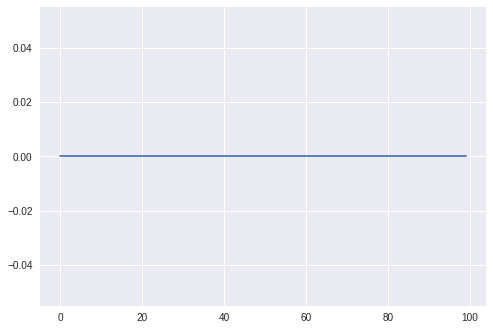

In [15]:
_ = pd.Series(tamanho_da_fila).plot()

### Aleatoriedade

In [0]:
from scipy.stats import poisson

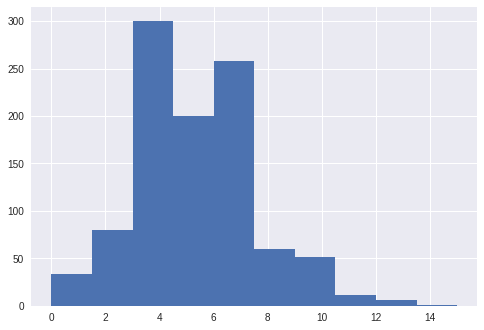

In [17]:
_ = pd.Series(poisson(5).rvs(1000)).hist()

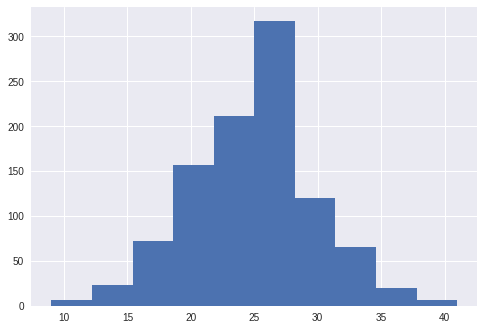

In [12]:
_ = pd.Series(poisson(25).rvs(1000)).hist()

In [0]:
def client(env, caixa):
    req = caixa.request()
    yield req
    yield env.timeout(poisson(3).rvs())
    caixa.release(req)

def client_generator(env, caixa):
    while True:
        env.process(client(env, caixa))
        yield env.timeout(poisson(2).rvs())

tamanho_da_fila = []
def observador(env, caixa):
    while True:
        tamanho_da_fila.append(len(caixa.queue))
        yield env.timeout(1)

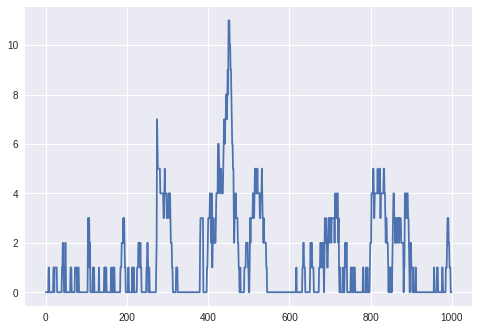

In [19]:
env = simpy.Environment()
caixa = simpy.Resource(env, capacity=2)
env.process(client_generator(env, caixa))
env.process(observador(env, caixa))
env.run(until=1000)
_ = pd.Series(tamanho_da_fila).plot()

### ```Resource``` modela o acesso a um recurso discreto (caixa do banco) que é ocupado e depois liberado

### ```Container``` modela o acesso a um recurso aproximadamente contínuo (ex: gasolina, ou maças, ou dinheiro) que é consumido e/ou reposto

In [0]:
from scipy.stats import uniform

In [0]:
def client(env, caixa, cofre):
    req = caixa.request()
    yield req
    yield cofre.get(uniform(10, 10000).rvs())
    yield env.timeout(poisson(3).rvs())
    caixa.release(req)

def client_generator(env, caixa, cofre):
    while True:
        env.process(client(env, caixa, cofre))
        yield env.timeout(poisson(2).rvs())

tamanho_da_fila = []
resta_no_cofre = []
def observador(env, caixa, cofre):
    while True:
        tamanho_da_fila.append(len(caixa.queue))
        resta_no_cofre.append(cofre.level)
        yield env.timeout(1)

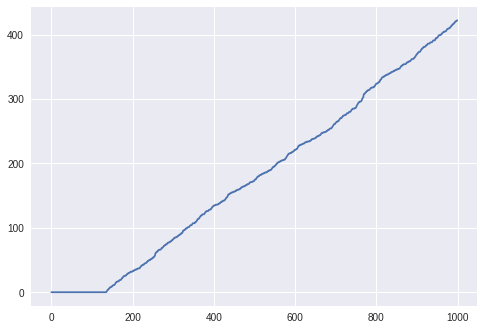

In [26]:
env = simpy.Environment()

caixa = simpy.Resource(env, capacity=50)
cofre = simpy.Container(env, 100000, init=100000)

env.process(client_generator(env, caixa, cofre))
env.process(observador(env, caixa, cofre))
env.run(until=1000)
_ = pd.Series(tamanho_da_fila).plot()

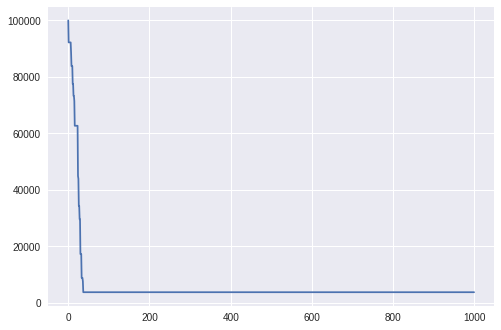

In [18]:
_ = pd.Series(resta_no_cofre).plot()

### Reposição de estoque

In [0]:
def client(env, caixa, cofre):
    req = caixa.request()
    yield req
    yield cofre.get(uniform(10, 1000).rvs())
    yield env.timeout(poisson(3).rvs())
    caixa.release(req)

def client_generator(env, caixa, cofre):
    while True:
        env.process(client(env, caixa, cofre))
        yield env.timeout(poisson(2).rvs())
        
def repositor(env, cofre):
    while True:
        if cofre.level < cofre.capacity * 0.3:
            yield env.timeout(300)
            yield cofre.put(cofre.capacity - cofre.level)
        else:
            yield env.timeout(5)

tamanho_da_fila = []
resta_no_cofre = []
def observador(env, caixa, cofre):
    while True:
        tamanho_da_fila.append(len(caixa.queue))
        resta_no_cofre.append(cofre.level)
        yield env.timeout(1)

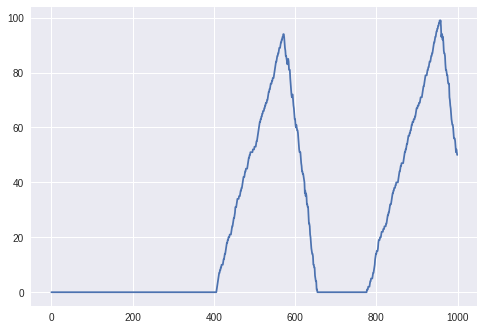

In [28]:
env = simpy.Environment()

caixa = simpy.Resource(env, capacity=5)
cofre = simpy.Container(env, 100000, init=100000)

env.process(client_generator(env, caixa, cofre))
env.process(observador(env, caixa, cofre))
env.process(repositor(env, cofre))
env.run(until=1000)
_ = pd.Series(tamanho_da_fila).plot()

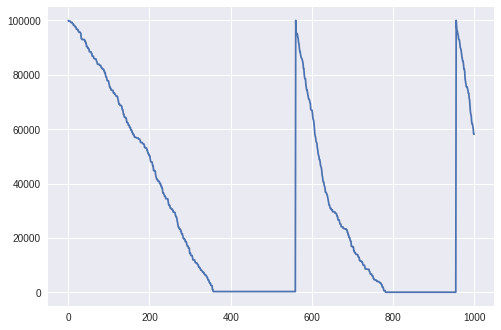

In [21]:
_ = pd.Series(resta_no_cofre).plot()